In [1]:
from pyOpenBCI import OpenBCICyton
import numpy as np
import time
import matplotlib.pyplot as plt
import pyeeg
import threading
from neurodsp import filt
from scipy import signal
import os
import pickle
import pyxdf
from enum import Enum

import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys, pathlib
sys.path.insert(0, str(pathlib.Path().absolute().parent))

from helper_scripts.helperFunctions import epochByMarkIndex, loadData, getArticleSectionData, loadxdf, writeToPickle, loadPickle, filterEEG
from helper_scripts.constants import StreamType
from helper_scripts.dataAnalysisFunctions import getIntervals, getPowerRatio, getCleanedSignal_EEGList


In [3]:
from neurodsp import spectral, plts
from neurodsp.plts.time_series import plot_time_series


In [4]:
from neurodsp.plts.filt import plot_filter_properties
from neurodsp.filt.utils import compute_frequency_response
from neurodsp.plts.filt import plot_frequency_response

In [5]:
DEFAULT_SECONDS = 3
DEFAULT_FS = 250
DEFAULT_CHANNELS = [0, 1, 2, 3, 4, 5, 6, 7]
DEFAULT_BINNING=[4, 8, 12, 20, 30]
DEFAULT_UPDATE_SECONDS = 0.5
SCALE_FACTOR_EEG = (4500000)/24/(2**23-1) #uV/count
F_RANGE=(0.5, 50)

In [6]:
class SamePlotter:
    def __init__(self, fs=DEFAULT_FS, buffer_seconds=DEFAULT_SECONDS, num_lines=len(DEFAULT_CHANNELS), x_label="timepoints", y_label="output", y_lim=(0,1)):
        self.fs = fs
        self.buffer_seconds = buffer_seconds
        self.num_lines = num_lines
        fig,ax = plt.subplots(1,1) # figsize=(20,10)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        x_lim=(0,self.fs * self.buffer_seconds) 
        ax.set_xlim(x_lim[0],x_lim[1])
        ax.set_ylim(y_lim[0],y_lim[1])
        self.x = np.linspace(x_lim[0], x_lim[1], self.fs * self.buffer_seconds)
        self.ax = ax
        self.fig = fig

    def __prepend_zeros(self, data, complete_length):
        # Prepends the data with arrays of zeros until it reaches the complete length needed for the buffer
        new_data = np.zeros((complete_length, self.num_lines))
        count = 0
        for i in range(complete_length - len(data), complete_length):
            new_data[i] = data[count]
            count += 1
        return new_data

    def plot(self, y_datas):
        complete_length = self.fs * self.buffer_seconds
        if len(y_datas) < complete_length:
            y_datas = self.__prepend_zeros(y_datas, complete_length)
        
        if self.ax.lines:
            for i, line in enumerate(self.ax.lines):
                line.set_ydata(y_datas[:, i])
        else :
            for data in range(self.num_lines): 
                self.ax.plot(self.x, y_datas[:,data])
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
            

In [7]:
class EEGSampler:
    """ Holds a buffer of EEG data and accepts a single data sample as input to append to the buffer
    """
    def __init__(self, fs=DEFAULT_FS, buffer_seconds=DEFAULT_SECONDS, update_seconds=DEFAULT_UPDATE_SECONDS, channels=DEFAULT_CHANNELS, binning=DEFAULT_BINNING, live=True, model=None, to_clean=True, three_class=False):
        self.fs = fs
        self.buffer_seconds = buffer_seconds
        self.channels = channels # These are the channels we want
        
        self.live = live
        self.model = model
        
        self.buffer = np.zeros((fs * buffer_seconds, len(channels)))
        self.raw_buffer = np.zeros((fs * buffer_seconds, len(channels)))
        self.dc_removed_buffer = np.zeros((fs * buffer_seconds, len(channels)))
        
        self.binning = binning
        self.intervals = getIntervals(self.binning)
        self.power_bin_values = np.zeros((fs * buffer_seconds, len(self.intervals), len(self.channels)))
        self.focus = np.zeros((fs * buffer_seconds))
        self.focus_average = np.zeros((fs * buffer_seconds))
        self.update_seconds = update_seconds
        self.last_updated = time.time()
        self.mean = np.zeros(len(channels))
        self.count_samples = 0
        self.num_focused = 0 
        self.to_clean = to_clean
        self.three_class = three_class
        
        ## Realtime filtering 
        ## https://stackoverflow.com/questions/40483518/how-to-real-time-filter-with-scipy-and-lfilter
        ## This is how it works? 
        ## https://www.drdobbs.com/real-time-filters/184401931?pgno=1
        # Bandpass filter 
        #self.bandpass_filter_b, self.bandpass_filter_a = filt.design_iir_filter(fs, pass_type='bandpass', f_range=F_RANGE, butterworth_order=2)
        #self.bandpass_filter_z = signal.lfilter_zi(self.bandpass_filter_b, self.bandpass_filter_a)
        
#         # FIR NOTCH FILTER 
#         self.notch_filter_b  = filt.design_fir_filter(fs, pass_type='bandstop', f_range=(58, 62), n_seconds=0.1)#, butterworth_order=8)
#         self.notch_filter_z = signal.lfilter_zi(self.notch_filter_b, [1])
#         f_db, db = compute_frequency_response(self.notch_filter_b, 1, fs)
        #plot_frequency_response(f_db, db)#, fs, self.notch_filter_b)
        
        # IIR NOTCH FILTER 
        #self.notch_filter_b, self.notch_filter_a = filt.design_iir_filter(fs, pass_type='lowpass', f_range=58, butterworth_order=8)
        #self.notch_filter_z = signal.lfilter_zi(self.notch_filter_b, self.notch_filter_a)
#         self.notch_filter_b2, self.notch_filter_a2 = filt.design_iir_filter(fs, pass_type='lowpass', f_range=59, butterworth_order=8)
#         self.notch_filter_z2 = signal.lfilter_zi(self.notch_filter_b2, self.notch_filter_a2)
        # f_db, db = compute_frequency_response(self.notch_filter_b, self.notch_filter_a, fs)
#         plot_frequency_response(f_db, db)#, fs, self.notch_filter_b)

        ## IIR Low Pass
#         self.notch_filter_b, self.notch_filter_a  = filt.design_iir_filter(fs, pass_type='lowpass', f_range=50, butterworth_order=8)
#         self.notch_filter_z = signal.lfilter_zi(self.notch_filter_b, self.notch_filter_a)
#         f_db, db = compute_frequency_response(self.notch_filter_b, self.notch_filter_a, fs)
        
    def __filter_eeg(self):
        # Bandpass + 60 Hz Notch
        for i, chan in enumerate(self.channels):
            self.buffer[:self.count_samples, i] = filterEEG(self.dc_removed_buffer[:self.count_samples, i], self.fs, F_RANGE)
        # ICA blink cleaning
        #self.buffer[:self.count_samples, [0, 1, 6, 7]] = getCleanedSignal_EEGList(self.buffer[:self.count_samples, [0, 1, 6, 7]], verbose=False)
#         Testing chunked filtering (windows too small)
#         timpoints_since_last = int(self.fs * self.update_seconds)
#         for i, chan in enumerate(self.channels):
#             self.buffer[:timpoints_since_last, i] = filterEEG(self.dc_removed_buffer[:timpoints_since_last, i], self.fs, F_RANGE)
#         self.buffer[:timpoints_since_last, [0, 1, 6, 7]] = getCleanedSignal_EEGList(self.buffer[:timpoints_since_last, [0, 1, 6, 7]], verbose=False)
        
    def __update_focus(self):
        data = np.transpose(self.buffer[:500])
        if self.three_class : 
            self.focus[0] = self.model.predict_classes(np.array([data]))[0]
        else :
            self.focus[0] = 2 if self.model.predict_classes(np.array([data]))[0] > 0 else 0
        self.focus_average[0] = np.mean(self.focus[:self.fs])
#     def __update_power_bin(self):
#         for chan in range(len(self.channels)):
#             eeg_data = self.buffer[:self.count_samples,chan]
#             self.power_bin_values[0, :, chan] = getPowerRatio(eeg_data, self.binning, eeg_fs=self.fs)
        # print(self.power_bin_values[0, :, :])
    def push_data_sample(self, sample):
        
        # Count the number of samples up till the full buffer (this is for mean calculation)
        if self.count_samples < self.fs * self.buffer_seconds: 
            self.count_samples += 1
        
        # Get the scaled channel data
        if self.live: 
            raw_eeg_data = np.array(sample.channels_data) * SCALE_FACTOR_EEG
        else :
            raw_eeg_data = np.array(sample) 
        
        # Roll and prepend the buffer with the new data
        self.raw_buffer = np.roll(self.raw_buffer, 1, 0)
        self.buffer = np.roll(self.buffer, 1, 0)
        self.dc_removed_buffer = np.roll(self.dc_removed_buffer, 1, 0)
        self.power_bin_values = np.roll(self.power_bin_values, 1, 0)
        self.focus = np.roll(self.focus, 1, 0)
        self.focus_average = np.roll(self.focus_average, 1, 0)
        for i, chan in enumerate(self.channels):
            self.raw_buffer[0, i] = raw_eeg_data[chan]
            if self.raw_buffer[0, i] == 0 : 
                continue
            if self.to_clean:  
                self.dc_removed_buffer[0, i] = self.raw_buffer[0,i] - self.mean[i]
                self.buffer[0, i] = self.dc_removed_buffer[0, i]
            else : 
                self.dc_removed_buffer[0, i] = self.raw_buffer[0, i] 
                self.buffer[0, i] = self.raw_buffer[0, i] 
            self.focus[0] = self.focus[1]
            self.focus_average[0] = np.mean(self.focus[:self.fs])
            #bandpassed_data, self.notch_filter_z = signal.lfilter(self.notch_filter_b, self.notch_filter_a, [self.dc_removed_buffer[0, i]], zi=self.notch_filter_z)
            #self.buffer[0,i], self.bandpass_filter_z = signal.lfilter(self.bandpass_filter_b, self.bandpass_filter_a, bandpassed_data, zi=self.bandpass_filter_z)
            
            #self.power_bin_values[0,:, i] = self.power_bin_values[1,:,i]
        
#         if (self.to_clean) and (self.count_samples > self.fs): 
#             self.mean = np.mean(self.raw_buffer[:self.count_samples], axis=0)
        
        # Calculate the new mean if the update time has passed
        now = time.time()
        if (now - self.last_updated) > self.update_seconds :
            self.last_updated = now
            if (self.count_samples > 500): 
                if (self.to_clean):
                    self.__filter_eeg()
                if (self.model is not None):
                    self.__update_focus()
                
            

In [8]:
# Import model
import torch
model_t = torch.load("models/model_t_combined_continuous_filtered_3class.pickle")



## Live data collection

In [55]:
board.stop_stream()

In [79]:
board = OpenBCICyton()
sampler = EEGSampler(buffer_seconds=5, model=model_t, three_class=True)
eeg_thread = threading.Thread(target=board.start_stream, args=(sampler.push_data_sample,))
eeg_thread.start()
print("thread started")

Serial established
thread started


<IPython.core.display.Javascript object>


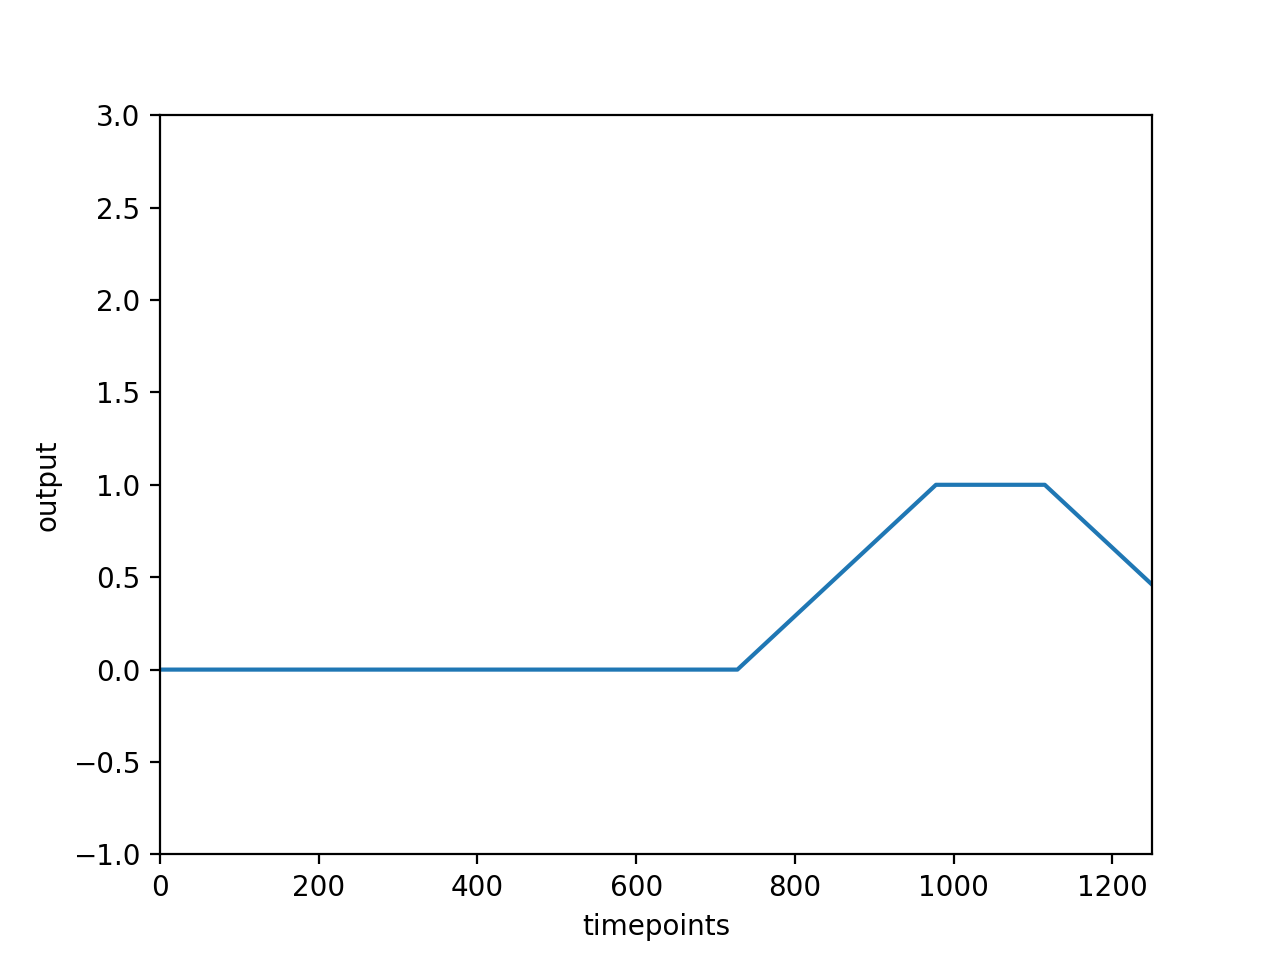

Skipped 100 bytes before start found


In [80]:
%matplotlib notebook

NUM_TIMES = 500
sameplotter = SamePlotter(buffer_seconds=5, num_lines=1, y_lim=(-1, 3))
for i in range(NUM_TIMES) :
    #arr_to_plot = sampler.buffer
    arr_to_plot = np.transpose(np.array([sampler.focus_average]))
    sameplotter.plot(arr_to_plot)
    time.sleep(0.05)

board.stop_stream()

In [ ]:
# writeToPickle(sampler.raw_buffer, "sampler_raw_buffer_eye_close_2.pickle")
# writeToPickle(sampler.buffer, "sampler_buffer_small_eye_close_2.pickle")

### Visualize Live Data

In [ ]:
# Filtered signal 

freqs, psds = spectral.compute_spectrum(sampler.buffer[:len(sampler.buffer)//3,0], DEFAULT_FS, method='welch', avg_type='mean', nperseg=DEFAULT_FS*2)
plt.plot(freqs[0:3*len(freqs)//5], np.log(psds[0:3*len(freqs)//5]))
plt.title("PSD after filtering")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power log(uV^2 / Hz)")
plt.ylim(-8, 12)
plt.show()


In [ ]:
# Original (dc removed)

freqs, psds = spectral.compute_spectrum(sampler.dc_removed_buffer[:len(sampler.buffer)//3,0], DEFAULT_FS, method='welch', avg_type='mean', nperseg=DEFAULT_FS*2)
plt.plot(freqs[0:3*len(freqs)//5], np.log(psds[0:3*len(freqs)//5]))
plt.title("PSD before filter")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power log(uV^2 / Hz)")
plt.ylim(-8, 12)
plt.show()


In [ ]:
# Filtered signal 

plt.plot(sampler.buffer[:len(sampler.buffer)//3,2])
plt.title("uV after filter")
plt.xlabel("Timepoints Before fs: " + str(DEFAULT_FS))
plt.ylabel("uV")
plt.ylim(-400, 400)
plt.show()

In [ ]:
# Original (dc removed)

plt.plot(sampler.dc_removed_buffer[:len(sampler.buffer)//3,2])
plt.title("uV before filter")
plt.xlabel("Timepoints Before fs: " + str(DEFAULT_FS))
plt.ylabel("uV")
plt.ylim(-400, 400)
plt.show()

## Load + Analyze recorded live data for offline live testing

In [ ]:
sampler_raw_buffer = loadPickle("realtime_data/sampler_raw_buffer_small_noise.pickle")
sampler_buffer = loadPickle("realtime_data/sampler_buffer_small_noise.pickle")
sampler_raw_buffer = loadPickle("realtime_data/sampler_buffer_small_eye_close.pickle")

In [ ]:
# Testing recorded samples with model
%matplotlib notebook
another_sampler = EEGSampler(live=False, model=model_t, three_class=True)
sameplotter = SamePlotter(y_lim=(-3, 3), num_lines=1)
original_data = sampler_raw_buffer
for i in range(len(original_data) - 1, -1, -1): 
    sample = [original_data[i, 0], original_data[i, 1], 0, 0, 0, 0, original_data[i, 2], original_data[i, 3]]
    another_sampler.push_data_sample(sample)
    if i % 20 == 0: 
        arr_to_plot = np.transpose(np.array([another_sampler.focus]))
        #arr_to_plot = another_sampler.buffer 
        #arr_to_plot = another_sampler.power_bin_values[:, :, 2]
        sameplotter.plot(arr_to_plot)
    
    

In [ ]:
# (fs, pass_type='lowpass', f_range=58, butterworth_order=8)

freqs, psds = spectral.compute_spectrum(another_sampler.buffer[:len(another_sampler.buffer)//3,0], DEFAULT_FS, method='welch', avg_type='mean', nperseg=DEFAULT_FS*2)
plt.plot(freqs[0:3*len(freqs)//5], np.log(psds[0:3*len(freqs)//5]))
plt.title("PSD after filtering")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power log(uV^2 / Hz)")
plt.ylim(-8, 9)
plt.show()



In [ ]:
# Original
freqs, psds = spectral.compute_spectrum(another_sampler.raw_buffer[:len(another_sampler.buffer)//3,0], DEFAULT_FS, method='welch', avg_type='mean', nperseg=DEFAULT_FS*2)
plt.plot(freqs[0:3*len(freqs)//5], np.log(psds[0:3*len(freqs)//5]))
plt.title("PSD before filtering")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power log(uV^2 / Hz)")
plt.ylim(-8, 9)
plt.show()




## Load pre-recorded data used for training

In [26]:
'''
# Files that work with this notebook: 
P001/part_P001_block_S004.xdf
P001/part_P001_block_S005.xdf
P001/part_P001_block_S006.xdf


'''
foldername="P001"
filename="part_P001_block_S006"
path = "../data/filtered_data/"+foldername+"/"+filename+".pickle"
loaded_data = loadPickle(path)#loadxdf(path)

loaded_data1 = getArticleSectionData("response", 0, loaded_data)
loaded_data2 = getArticleSectionData("response", 1, loaded_data)

loaded_eeg_data = np.array(list(loaded_data1['eeg']['data']) + list(loaded_data2['eeg']['data']))
loaded_eeg_time = np.array(list(loaded_data1['eeg']['time']) + list(loaded_data2['eeg']['time']))
df = loadData(datatype='dataframe', foldername=foldername, filename=filename)



In [27]:
models_to_test = ["models/model_t_combined_trimmed_filtered.pickle", 
                  "models/model_t_combined_continuous_filtered.pickle", 
                  "models/model_t_combined_trimmed_filtered_3class.pickle", 
                  "models/model_t_combined_continuous_filtered_3class.pickle"]

start_start_time = time.time()
for model_filename in models_to_test:
    model_t = torch.load(model_filename)
    
    to_clean = False
    three_class = False
    if "cleaned" in model_filename: 
        print("cleaning!")
        to_clean = True
    if "3class" in model_filename: 
        print("3 class!")
        three_class = True
        
    loaded_sampler = EEGSampler(update_seconds=0.08, live=False, model=model_t, to_clean=to_clean, three_class=three_class)
    original_data = loaded_eeg_data[::-1]
    original_time = loaded_eeg_time[::-1]
    
    prev_df_time = 0
    squared_errors = []
    actual_focus = 0 
    
    exact_correct = 0
    num_opposite_error = 0
    num_half_error = 0
    
    start_time = time.time()
    for i in range(len(original_data) - 1, -1, -1): 
        current_time = original_time[i]
        elem = df[(df['time'] <= current_time) & (df['time'] >= prev_df_time)]
        if len(elem) > 0: 
            elem = elem.iloc[-1]
            actual_focus = 2 if elem['trial_time'] <= 0.7 else 1 if elem['trial_time'] <= 0.9 else 0
            prev_df_time = elem['time']
        else :
            print("no df")
        sample = [original_data[i, 0], original_data[i, 1], 0, 0, 0, 0, original_data[i, 6], original_data[i, 7]]
        loaded_sampler.push_data_sample(sample)
        squared_errors.append(pow(loaded_sampler.focus_average[0] - actual_focus, 2))
        if loaded_sampler.focus[0] == actual_focus : 
            exact_correct += 1 
        elif abs(loaded_sampler.focus[0] - actual_focus) > 1: 
            num_opposite_error += 1
        elif abs(loaded_sampler.focus[0] - actual_focus) == 1: 
            num_half_error += 1 
            
    
        
    print(model_filename)
    print("\tExact correct", exact_correct / len(original_data))
    print("\tApproximate correct", (len(original_data) - num_opposite_error - 0.5 * num_half_error) / len(original_data))
    print("\tMSE:", sum(squared_errors) / len(squared_errors))
    
    end_time = time.time()
    elapsed = end_time - start_time
    print("\ttime taken:", elapsed, "s")
    
end_time = time.time()
elapsed = end_time - start_start_time
print("total time taken:", elapsed, "s")

no df
no df
models/model_t_combined_trimmed_filtered.pickle
	Exact correct 0.3337337709664286
	Approximate correct 0.5295578263776144
	MSE: 0.899133829232481
	time taken: 374.1789560317993 s
no df
no df
models/model_t_combined_continuous_filtered.pickle
	Exact correct 0.44715982487974304
	Approximate correct 0.6429838802909288
	MSE: 1.0212962571111355
	time taken: 384.82405495643616 s
3 class!
no df
no df
models/model_t_combined_trimmed_filtered_3class.pickle
	Exact correct 0.4145936898401098
	Approximate correct 0.6295658686397017
	MSE: 0.7803622200262299
	time taken: 418.88769602775574 s
3 class!
no df
no df
models/model_t_combined_continuous_filtered_3class.pickle
	Exact correct 0.4248224419323545
	Approximate correct 0.6752660229506054
	MSE: 0.7163187849751252
	time taken: 421.849956035614 s
total time taken: 1599.8423850536346 s


In [ ]:
# Test single model with visualization
%matplotlib notebook
loaded_sampler = EEGSampler(update_seconds=0.05, live=False, model=model_t, to_clean=False)
sameplotter = SamePlotter(y_lim=(-5, 5), num_lines=2)
original_data = loaded_eeg_data[::-1]
original_time = loaded_eeg_time[::-1]
actual_focus = np.zeros((len(loaded_sampler.focus)))
prev_df_time = 0
squared_errors = []
for i in range(len(original_data) - 1, -1, -1): 
    current_time = original_time[i]
    elem = df[(df['time'] <= current_time) & (df['time'] >= prev_df_time)]
    if len(elem) > 0: 
        #print(len(elem))
        elem = elem.iloc[-1]
        actual_focus = np.roll(actual_focus, 1, 0)
        actual_focus[0] = 1 if elem['trial_time'] <= 0.7 else 0 if elem['trial_time'] <= 0.9 else -1
        prev_df_time = elem['time']
    else :
        print("no df")
    sample = [original_data[i, 0], original_data[i, 1], 0, 0, 0, 0, original_data[i, 6], original_data[i, 7]]
    loaded_sampler.push_data_sample(sample)
    squared_errors.append(pow(loaded_sampler.focus_average[0] - actual_focus[0], 2))
    
    if i % 50 == 0: 
        arr_to_plot = np.transpose(np.append([loaded_sampler.focus_average], [actual_focus], axis=0))
        #arr_to_plot = loaded_sampler.buffer 
        #arr_to_plot = loaded_sampler.power_bin_values[:, :, 2]
        sameplotter.plot(arr_to_plot)
    
print("MSE:", sum(squared_errors) / len(squared_errors))


In [ ]:
print("continuous model MSE:", sum(squared_errors) / len(squared_errors))


In [ ]:
print("epoched model MSE:", sum(squared_errors) / len(squared_errors))


In [ ]:
 len(squared_errors) == len(original_time)

In [ ]:
# PSD of loaded data 

freqs, psds = spectral.compute_spectrum(loaded_sampler.dc_removed_buffer[:len(loaded_sampler.buffer)//3,0], DEFAULT_FS, method='welch', avg_type='mean', nperseg=DEFAULT_FS*2)
plt.plot(freqs[0//5:3*len(freqs)//5], np.log(psds[0//5:3*len(freqs)//5])) 
plt.title("PSD before filter")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power log(uV^2 / Hz)")
plt.ylim(-8, 9)
plt.show()